* The jupyter notebook for you to start from in the repo: TODO

# Preliminaries

This tutorial is presented at the [NYC AI & ML meetup](https://www.meetup.com/NYC-Artificial-Intelligence-Machine-Learning/events/260064765/).

We have the ambitious goal for this tutorial to be an introduction to both
* Generative Adversarial Networks (GANs) and
* pytorch

Since GANs are a more advanced topic in deep learning, we will introduce the deep learning concepts only at an intuitive level in function of GANs.

We will show concepts in code as soon as possible.
We try to strip away complexity, abstractions and generalizations that would get in the way of absorbing the concepts.

Here is what you will learn
* GANs are generative models that learn to generate data, based on a min-max game between a Generator (G) and Discriminator (D).
* The parameters of both Generator and Discriminator are optimized via Stochastic Gradient Descent (SGD).
* SGD optimization needs the gradient of a loss function with respect to the parameters. This is automatically computed with pytorch's autograd.
* Doing many (SGD) updates of the neural network weights based on a loss function is the core of all deep learning optimization.

# 1. GAN first introduction
[GAN picture](figs/gan_xavigiro.png)

<img src="figs/gan_xavigiro.png" alt="GAN picture" style="width: 500px;"/>

GANs are a class of unsupervised generative models.
*the bland intro. try to keep text minimal*

Let's start with defining the generator G and discriminator D in pytorch.

# 2. Define the neural networks in pytorch

In [1]:
# if running on colab, pytorch is already installed.
# if running locally, conda or pip install this in your conda environment:
# conda install pytorch torchvision -c pytorch
# OR
# pip3 install torch torchvision

# I'll be assuming python >=3.6 and torch 1.0.1 which currently are the colab defaults.

In [2]:
import sys
print(sys.version) # python 3.6
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn.functional as F
print(torch.__version__) # 1.0.1

%matplotlib notebook
import matplotlib.pyplot as plt

3.6.6 |Anaconda custom (64-bit)| (default, Jun 28 2018, 11:07:29) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
1.0.0.dev20181130


## torch basics

PyTorch is a package that defines vectors, matrices, or in general "tensors". If you know numpy, you will not be surprised by any of these:

In [ ]:
a = torch.ones(3,3)
a

In [ ]:
b = torch.arange(9).float().view(3,3)
b

In [ ]:
(a+b)**2

In [ ]:
b[:,0]

In [ ]:
a.zero_() # operations with an underscore modify the Tensor in place.
a

You can slice and dice tensors and they have roughly all tensor operations you expect equivalently to numpy, but with a bit more low level control. If you need more intro: https://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html#sphx-glr-beginner-blitz-tensor-tutorial-py

So what's the big deal about pytorch?

**autograd = automatic differentiation** which allows to compute derivatives of a computation sequence (graph) automatically. More about this later.

## Defining the neural networks

Let's define a small 2-layer fully connected neural network (so one hidden layer) for the discriminator `D`:

In [47]:
class Discriminator(nn.Module):
    def __init__(self, inp_dim=784):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(inp_dim, 128)
        self.nonlin1 = nn.LeakyReLU(0.2)
        self.fc2 = nn.Linear(128, 1)
    def forward(self, x):
        x = x.view(x.size(0), -1) # flatten (bs x 1 x 28 x 28) -> (bs x 784)
        h = self.nonlin1(self.fc1(x))
        out = self.fc2(h)
        out = torch.sigmoid(out)
        return out

And a small 2-layer neural network for the generator `G`. `G` takes a 100-dimensional noise vector and generates an output of the size matching the data.

In [48]:
class Generator(nn.Module):
    def __init__(self, z_dim=100):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(z_dim, 128)
        self.nonlin1 = nn.LeakyReLU(0.2)
        self.fc2 = nn.Linear(128, 784)
    def forward(self, x):
        h = self.nonlin1(self.fc1(x))
        out = self.fc2(h)
        out = torch.tanh(out) # range [-1, 1]
        # convert to image 
        out = out.view(out.size(0), 1, 28, 28)
        return out
    

In [49]:
# instantiate one network according to this definition.
D = Discriminator()
# A small batch of 3 samples, all zeros.
samples = torch.zeros(3, 1, 28, 28) # batch size x channels x width x height
# This is how to do a forward pass (calls the .forward() function under the hood)
D(samples)

tensor([[0.5181],
        [0.5181],
        [0.5181]], grad_fn=<SigmoidBackward>)

Things to try:
* What happens if you change the number of samples in a batch?
* What happens if you change the width/height of the input?
* What are the parameters(weights) of the discriminator? You can get an iterator over them with `.parameters()` and `.named_parameters()`

In [24]:
for name, p in D.named_parameters():
    print(name, p.shape)

fc1.weight torch.Size([128, 784])
fc1.bias torch.Size([128])
fc2.weight torch.Size([1, 128])
fc2.bias torch.Size([1])


We will think of the concatentation of all these discriminator weights in one big vector as $\theta_D$.

In [16]:
# instantiate one network according to this definition:
G = Generator()
# A small batch of 3 samples, random noise.
z = torch.randn(3, 100)
# This is how to do a forward pass (calls the .forward() function under the hood)
G(z)

tensor([[-0.0425, -0.0091, -0.0934,  ..., -0.0199,  0.2815,  0.3203],
        [-0.0165, -0.0039, -0.2877,  ..., -0.0580,  0.2092,  0.2232],
        [ 0.0596,  0.2376,  0.1513,  ...,  0.2066,  0.2248,  0.4650]],
       grad_fn=<AddmmBackward>)

## Testing the neural networks (forward pass)

The size of D input and G output was defined for MNIST data.

In [18]:
# instantiate a discriminator according to the class definition.
D = Discriminator()
# A small batch of 3 samples, all zeros.
samples = torch.zeros(3, 1, 28, 28) # batch size x channels x width x height
# This is how to do a forward pass (calls the .forward() function under the hood)
D(samples)

tensor([[-0.0765],
        [-0.0765],
        [-0.0765]], grad_fn=<AddmmBackward>)

Things to try:
* What happens if you change the number of samples in a batch?
* What happens if you change the width/height of the input?
* What are the weights of the discriminator? You can get an iterator over them with `.parameters()` and `.named_parameters()`

In [24]:
for name, p in D.named_parameters():
    print(name, p.shape)

fc1.weight torch.Size([128, 784])
fc1.bias torch.Size([128])
fc2.weight torch.Size([1, 128])
fc2.bias torch.Size([1])


In [39]:
# instantiate one network according to this definition:
G = Generator()
# A small batch of 3 samples, random noise.
z = torch.randn(2, 100)
# This is how to do a forward pass (calls the .forward() function under the hood)
x_gen = G(z)
x_gen.shape

torch.Size([2, 1, 28, 28])

## Loading the data and computing forward pass

In [33]:
# let's download the MNIST data, if you do this locally and you downloaded before,
# you can change data paths to point to your existing files
dataset = dsets.MNIST(root='./MNISTdata',
                       transform=transforms.Compose([transforms.ToTensor(),
                                                     transforms.Normalize((0.5,), (0.5,))]),
                       download=True)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

Dataset and DataLoader are abstractions to help us iterate over the data in random order.

Let's look at a digit and its label

<IPython.core.display.Javascript object>


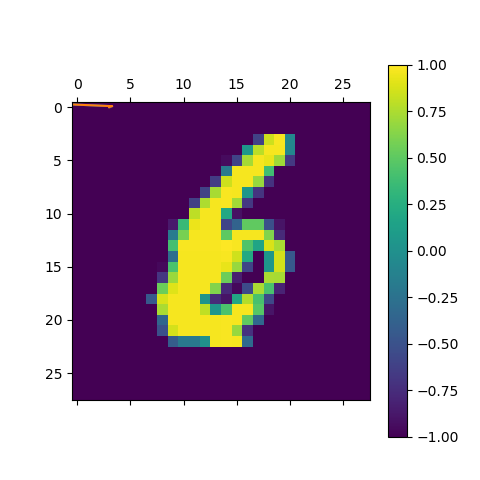

In [51]:
ix=129
x, _ = dataset[ix]
plt.matshow(x.squeeze().numpy())
plt.colorbar()

Feed the image into the discriminator; the output will be the probability the (untrained) discriminator assigns to this sample being real.

In [65]:
# for one image:
Dscore = D(x)
Dscore

tensor([[0.6237]], grad_fn=<SigmoidBackward>)

In [66]:
# How you can get a batch of images from the dataloader:
xbatch, _ = iter(dataloader).next() # 64 x 1 x 28 x 28: minibatch of 64 samples
#D(xbatch) # 64x1 tensor: 64 predictions of "real" probability
D(xbatch).shape

torch.Size([64, 1])

# 3 Intermezzo: optimization with SGD - linear regression example

We will step away from GANs for a second to introduce the core of deep learning: optimization with SGD.

Here are the core components of a basic deep learning classifier/regression setup:
* a neural network $\hat{y}=f(x, \theta)$, which takes an input $x$ and parameters $\theta$, and outputs a prediction of $y$.
* a loss function $\mathcal{L}(\theta) = \mathbb{E}_{x,y \sim p_d} \ell(f(x, \theta), y) \approx \sum_{x_i,y_i \sim mb} \ell(f(x_i, \theta), y_i)$.
* optimizing $\theta$ to reduce the loss, by making small updates to $\theta$ in the direction of $-\nabla_\theta \mathcal{L}(\theta)$.

pytorch is designed around these core components:
* The way to define a neural network is with `torch.nn.Module`, see how we defined the Discriminator and Generator above.
    - a module defines its parameters $\theta$ and defines the operations done with them.
    - initializing a module initializes the weights at random
* $\theta$ stands for all our neural network weights (everything you get from `.parameters()`)
* In the optimization loop you will evaluate a "minibatch" of samples (in our case 64) to compute the neural network output, and the loss measuring how far away those predictions are from the truth.
* To compute the gradient $\nabla_\theta \mathcal{L}(\theta)$, you call `.backward()` on the loss. This is where the magic happens: the gradient wrt all weights in the neural network is computed. They appear in a new Tensor `p.grad` for each `p in net.parameters()`
    - under the hood, this happens by keeping track of the computational graph, and reversing the computation order to "backpropagate" the loss with the chain rule.

A side note about optimization:
- optimization through small consecutive steps along the gradient $-\nabla_\theta \mathcal{L}(\theta)$ is called gradient descent, the stochastic version is stochastic gradient descent (SGD).
- (S)GD is probably the simplest optimization algorithm, you can do much more complex things like combining gradients along multiple timesteps, take curvature information into account, etc.
- in deep learning, SGD and (mostly heuristic) variations like Adam are the workhorse.


### 3a: basic autograd example

So we said the big deal about pytorch (or other deep learning package) is **autograd = automatic differentiation** which allows to compute derivatives automatically.

Every `torch.Tensor`, let's say `x`, has an important flag `requires_grad`. If this flag is set to True, pytorch will keep track of the graph of operations that happen with this tensor.
When we finally arrive at some output (a scalar variable based on a sequence of operations on `x`), we can call `.backward()` on this output, to compute the gradient `d(output) / dx`. This gradient will end up in `x.grad`.

In [ ]:
x = torch.randn(2,2, requires_grad=True)
x

In [ ]:
y=(x**2 + x)
z = y.sum()
z

We know from high school math that the derivative `dz / dx[i,j]` = 2*x +1

In [ ]:
z.backward()
x.grad

In [ ]:
2*x+1

You can play with this: you can introduce any tensor operation here; for example `torch.exp(torch.sin(x**2))`. Confirm that the gradient matches the analytical derivative.

More about autograd in the tutorial https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html#sphx-glr-beginner-blitz-autograd-tutorial-py and the docs https://pytorch.org/docs/stable/autograd.html


This was a very basic example of what pytorch autograd does for us: computing the derivatives of a scalar function $z(x)$ wrt $x$: $\nabla_x z(x)$.
In a deep learning context this will be at the basis of our optimization; now we will have
* $\mathcal{L}(\theta)$  the loss is a (scalar) function of neural network parameters (vector) $\theta$.
* autograd will allow us to call `.backward()` on the loss, which will compute the gradient of the loss with respect to neural network parameters $\nabla_\theta \mathcal{L}(\theta)$.
* For each of the parameters `p` the gradient will be in `p.grad`

### 3b: Linear regression

Let's try this for a simple linear mapping `y = f(x, theta) = <x, theta>` with $x, \theta \in \mathbb{R}^{2}$. We we want to optimize W:

In [87]:
torch.manual_seed(23801)
x1 = torch.Tensor([1, 2, 3, -3, -2])
y = torch.Tensor ([3, 6, 9, -9, -6]).view(5,1)
x2 = torch.randn(5)
x = torch.stack([x1, x2], dim=1) # 5 x 2 input. 5 datapoints, 2 dimensions.
theta = torch.randn(1,2, requires_grad=True)
# we start theta at random initialization, the gradient will point us in the right direction.
print('x:\n', x)
print('y:\n', y)
print('theta at random initialization: ', theta)
thetatrace = [theta.data.clone()] # initial value, for logging

x:
 tensor([[ 1.0000, -0.9665],
        [ 2.0000, -0.4228],
        [ 3.0000,  0.2336],
        [-3.0000, -1.6804],
        [-2.0000,  1.6508]])
y:
 tensor([[ 3.],
        [ 6.],
        [ 9.],
        [-9.],
        [-6.]])
theta at random initialization:  tensor([[-0.4394, -0.2656]], requires_grad=True)


Take a look at x and y. What is their correct (linear) relationship?

A: `y = 3 x1 + 0 x2`

Now we define a prediction as a linear mapping $\hat{y} = (X . \theta)$

We will compute the ordinary least squares objective (mean squared error):  $\mathcal{L}(\theta) = (\hat{y}(x,\theta) - y)^2$

Compute $\nabla_\theta \mathcal{L}(\theta)$, and

Move $\theta$ a small step opposite to that direction

In [95]:
ypred = x @ theta.t() # matrix multiply; (N x 2) * (2 x 1) -> N x 1
print('ypred:\n', ypred)
loss = ((ypred-y)**2).mean() # mean squared error = MSE
print('mse loss: ', loss.item())
loss.backward()
print('dL / d theta:\n', theta.grad)
# let's move W in that direction
theta.data.add_(-0.1 * theta.grad.data)
# Now we will reset the gradient to zero.
theta.grad.zero_()
print('theta:\n', theta)
thetatrace.append(theta.data.clone()) # for logging

ypred:
 tensor([[ 3.0179],
        [ 6.0087],
        [ 8.9975],
        [-8.9716],
        [-6.0307]], grad_fn=<MmBackward>)
mse loss:  0.0004305322654545307
dL / d theta:
 tensor([[ 0.0015, -0.0480]])
theta:
 tensor([[ 3.0004, -0.0131]], requires_grad=True)


You can re-execute this cell above a couple of times and see how W goes close towards the optimal value of `[3,0]`.

In [97]:
thetatrace[0].shape

torch.Size([1, 2])

<IPython.core.display.Javascript object>


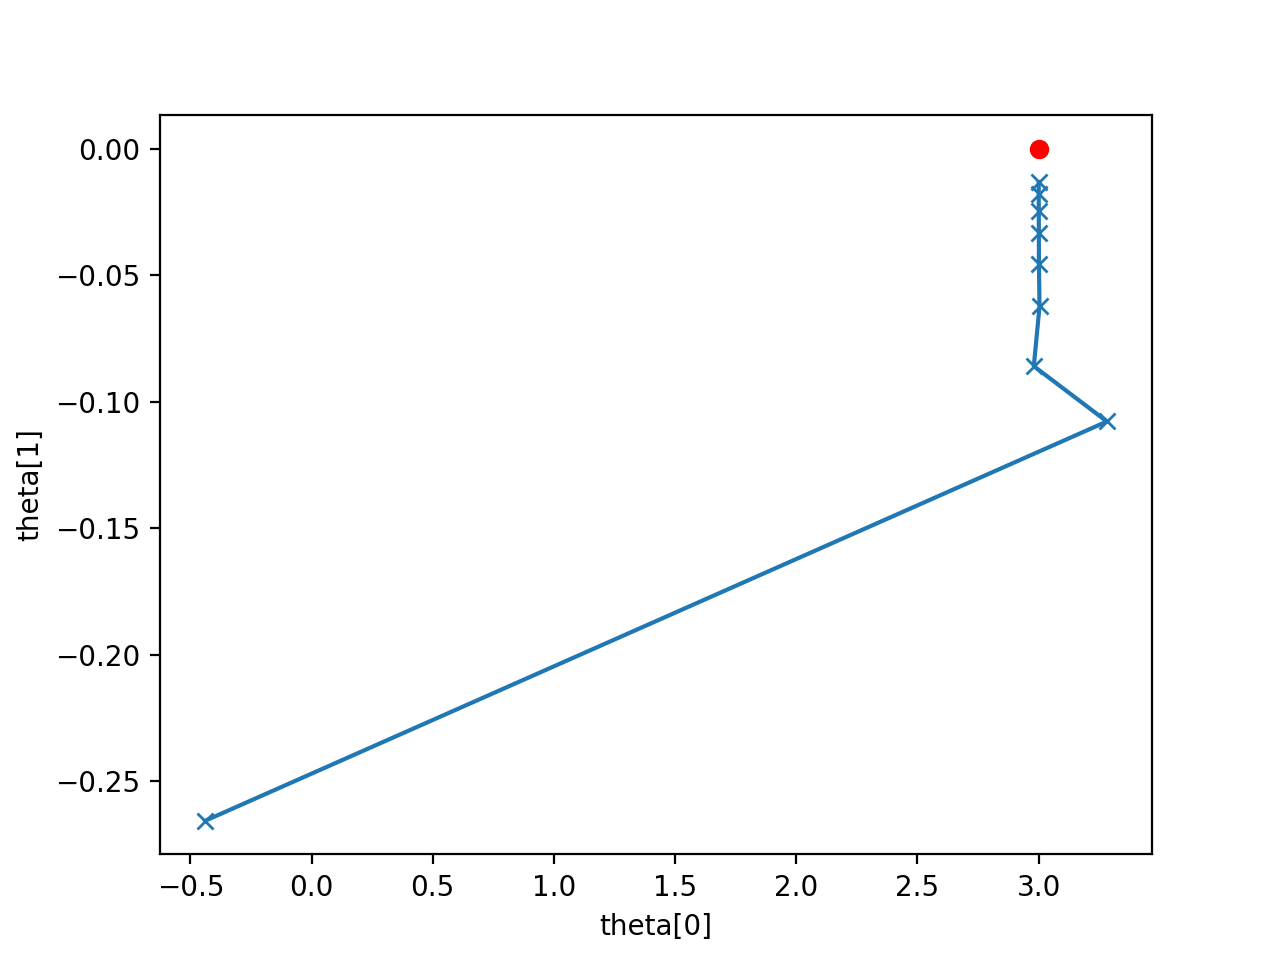

Text(0,0.5,'theta[1]')

In [104]:
# Now let us plot in 2D what happened to theta during SGD optimization. In red is the true relation.
# thetatrace = torch.cat(thetatrace, dim=0).numpy()
plt.figure()
plt.plot(thetatrace[:,0], thetatrace[:, 1], 'x-')
plt.plot(3, 0, 'ro')
plt.xlabel('theta[0]')
plt.ylabel('theta[1]')

Ok, doing this manually gives you insight what happens down to the details. But usually we do not do the gradient updates manually, it would become very cumbersome if the net becomes more complex than the simple linear layer. pytorch gives us abstractions to easily manage this complexity: 
* `nn.Linear()` (or generally  `Module`s) which do two things: (a) they contain the learnable weight, and (b) define how they operate on an input tensor to give an output.
* `module.zero_grad()` to clear the gradients, 
* `optim.SGD` with which you can do `optimizer.step()` to do a step of SGD.

In [109]:
torch.manual_seed(23801)
net = nn.Linear(2,1, bias=False)
optimizer = torch.optim.SGD(net.parameters(), lr=0.1) # do updates with `optimizer.step()`
# x, y defined above. In a real problem we would typically get different x, y "minibatches"
# of samples from a dataloader.
for i in range(100): # 10 optimization steps (gradient descent steps)
    ypred = net(x)
    loss = ((ypred-y)**2).mean() # mean squared error = MSE
    optimizer.zero_grad()
    loss.backward()
    # and instead of W.data -= 0.1 * W.grad we do:
    optimizer.step()
print(net.weight)

Parameter containing:
tensor([[3.0000e+00, 1.1281e-07]], requires_grad=True)


Indeed this is very close to the optimal $\theta=[3,0]$.

# 4. Back to GANs: The min-max game.

We introduced and defined the generator G, the discriminator D, and the dataloader which will give us minibatches of real data. With the intermezzo on optimization we also understand how we optimize neural networks in pytorch.

To recap the basic idea of the min-max / adversarial game:
* The Generator and Discriminator have competing objectives, they are "adversaries".
* The Discriminator wants to assign high probability to real images and low probability to generated (fake) images
* The Generator wants its generated images to look real, so wants to modify its outputs to get high scores from the Discriminator
* We will optimize both with SGD steps (as before): optimize $\theta_D$ the weights of $D(x, \theta_D)$, and  $\theta_G$ the weights of $G(z, \theta_G)$.

Now what are the objective functions for each of them? As mentioned in the introduction, the objective for the discriminator is to classify the real images as real, so $D(x) = 1$, and the fake images as fake, so $D(G(z))=0$.
This is a typical binary classification problem which calls for the binary cross-entropy (BCE) loss, which encourages exactly this solution.

For G we just try to minimize the same loss that D maximizes. See how G appears inside D? This shows how the output of the generator G is passed into the Discriminator to compute the loss.


This is the optimization problem:

$$
\min _{G} \max _{D} V(D, G)=\mathbb{E}_{\boldsymbol{x} \sim p_{\text { data }}(\boldsymbol{x})}[\log D(\boldsymbol{x})]+\mathbb{E}_{\boldsymbol{z} \sim p_{\boldsymbol{z}}(\boldsymbol{z})}[\log (1-D(G(\boldsymbol{z})))]
$$

We will do a single SGD step alternatingly to maximize D, then minimize G.
In fact for G we use a modified (non-saturing) loss $-\log D(G(z))$. Different modifications of the loss and the relation to the distance between distributions $p_{data}$ and $p_{G}$ became a topic of research over the last years.



References and further reading
* pytorch DCGAN [example](https://github.com/pytorch/examples/blob/master/dcgan/main.py) and [tutorial](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html) by Nathan Inkawhich
* [Medium blog post](https://medium.com/ai-society/gans-from-scratch-1-a-deep-introduction-with-code-in-pytorch-and-tensorflow-cb03cdcdba0f) by Diego Gomez Mosquera

# Now the real stuff: MNIST classification

MNIST is a dataset of 50k handwritten digits (0-9) which is very commonly used in the deep learning community.
It is small enough to work with locally (on your laptop) and without much hassle, and complex enough to do something interesting with.

The loss we will optimize is  $$\mathcal{L(\theta)} = \sum_{x,y_{t} \in D} \ell(x,y_t; \theta)$$
with $$\ell(x,y_t; \theta) = \text{NLL}(\hat{y}(x; \theta) || y_t)$$ the negative log likelihood loss. https://pytorch.org/docs/stable/nn.html#torch.nn.NLLLoss

Now we'll set up a small neural network to learn a good $\hat{y}(x; \theta)$. 
The variable $\theta$ simply means all the neural network weights together, which we will update on each step. So per sample, the neural network output $\hat{y}(x; \theta)$ is the model's prediction of the probability of each class.  This is being compared to the true label $y_t$.
The loss value is a metric of how far off the predictions are.
We want to minimize this loss with SGD (stochastic gradient descent)


We will follow the typical training procedure for a neural network which is as follows:

* Define the neural network that has some learnable parameters (or weights) $\theta$.
* Iterate over a dataset of inputs
* Process input through the network
* Compute the loss (how far is the output from being correct)
* Propagate gradients back into the network’s parameters
* Update the weights of the network, typically using SGD, i.e. the simple update rule: weight = weight - learning_rate * gradient


In [9]:
# let's download the MNIST data, if you do this locally and you downloaded before,
# you can change data paths to point to your existing files
train_dataset = dsets.MNIST(root='./MNISTdata',
                           train=True,
                           transform=transforms.ToTensor(),
                           download=True)

test_dataset = dsets.MNIST(root='./MNISTdata',
                           train=False,
                           transform=transforms.ToTensor())

Dataset and DataLoader are abstractions to help us iterate over the data in random order.

Let's look at the digits and their labels

<IPython.core.display.Javascript object>


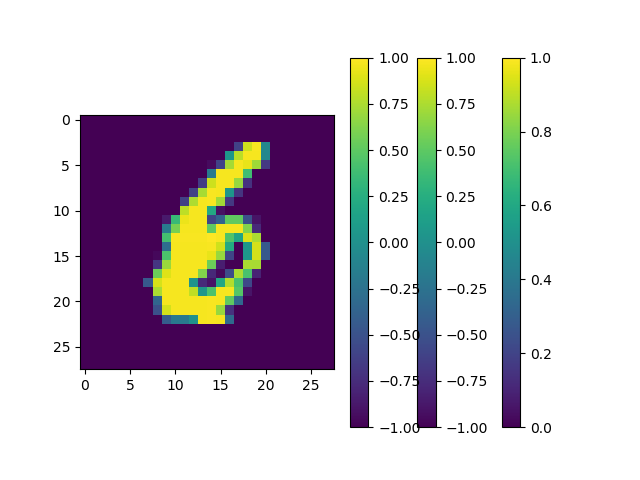

label: y=6


In [10]:
ix=129
x,y = train_dataset[ix]
plt.imshow(x.squeeze().numpy())
plt.colorbar()
print('label: y={}'.format(y))

In [ ]:
Now let's define the dataloaders and train simple neural network like before.
You'll recognize that the core is exactly the same: we do a forward pass, compute a loss, backpropagate the loss to compute the gradients, then let the optimizer update the weights.

In [ ]:
# The neural network hyperparameters.
input_size    = 784   # The MNIST image size = 28 x 28 = 784
hidden_size   = 100   # The number of nodes at the hidden layer
num_classes   = 10    # The number of output classes. In this case, from 0 to 9
num_epochs    = 5     # The number of times entire dataset is trained
batch_size    = 100   # The number of samples per minibatch
learning_rate = 1.0   # SGD step size

In [ ]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [ ]:
len(train_loader)

In [ ]:
device = torch.device('cpu') # if on gpu-enabled machine, change to torch.device('cuda')

#  define simple neural network with 1 hidden layer.
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(Net, self).__init__()                    # Inherited from the parent class nn.Module
        self.fc1 = nn.Linear(input_size, hidden_size)  # 1st Full-Connected Layer: 784 (input data) -> 500 (hidden node)
        self.relu = nn.ReLU()                          # Non-Linear ReLU Layer: max(0,x)
        self.fc2 = nn.Linear(hidden_size, num_classes) # 2nd Full-Connected Layer: 500 (hidden node) -> 10 (output class)
    
    def forward(self, x):                              # Forward pass: stacking each layer together
        x = x.view(x.size(0), -1) # flatten (bs x 1 x 28 x 28) -> (bs x 784)
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out
def test(net, dl):
    right, tot = 0, 0
    net.eval() # Set dropout and possibly other modules in eval mode.
    for x,y in dl:
        ypred = net(x).argmax(dim=1) # select index of maximal score
        right += (ypred == y).sum().item()
        tot   += x.size(0)
    return 1.* right / tot

In [ ]:
# create the net based on this class definition
net = Net(input_size, hidden_size, num_classes).to(device)
# define the optimizer
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)
print('Before training: {:.1f}% test accuracy'.format(100*test(net, test_loader)))
for epoch in range(num_epochs):
    scheduler.step()
    for i, (x,y_target) in enumerate(train_loader):
        x, y_target = x.to(device), y_target.to(device)
        y_probs = F.log_softmax(net(x), dim=1)
        output = F.nll_loss(y_probs, y_target)
        # TODO FILL IN: 1) call backward() on the output loss. 2) optimizer step. 3) zero the gradients.
        #
        #
        #
    print('After epoch {}: {:.1f}% test accuracy'.format(epoch, 100*test(net, test_loader)))
print('End of training: {:.1f}% train accuracy'.format(100*test(net, train_loader)))

In [ ]:
# show the prediction on some samples.
ix=1234
x,y = test_dataset[ix]
plt.imshow(x.squeeze().numpy())
print('Ground truth label: y={}'.format(y))
y_probs = F.softmax(net(x), dim=1)
print ('Model probabilities: ') 
print(' / '.join(['{}: {:.3f}'.format(k,v) 
                  for k,v in zip(range(10), y_probs.squeeze().tolist()) ] ))
print('Model prediction: ', y_probs.argmax(1))

Voila and that's how it's done. You can play around to figure out the answer to some more questions:
* What do we get back from `net.parameters()`: which trainable weights and biases does the network have now? 
* How many total parameters?
* Can you add another hidden layer to the class definition of `Net`? How does the performance change (watch both test & train)?
* Can you add a dropout layer after the first and second hidden layer? How does performance change now? See https://pytorch.org/docs/master/nn.html#torch.nn.Dropout


Some more fundamental questions for you to understand what's going on in the optimization loop:
* what does softmax do? (compute softmax of a random vector, then sum the output, it will sum to 1)
* what is its purpose? (read the docs)
* what does nll_loss compute? can you manually compute it?

Important questions to revisit after you learned about overfitting:
* How many parameters (weights) does our classifier neural network have? How many  datapoints did we train on?
* Old-skool machine learning rule of thumb is: you can optimize about as many parameters (weights) as you have datapoints before you can memorize the dataset (thus overfit heavily). Are we close to the limit?
* Does the model overfit? We are measuring this by splitting off a heldout set after loading the data on which you do not train, and measure performance on the heldout set.
* In deep neural networks you can easily have way more parameters than datapoints. Is overfitting an issue for neural networks in general?

Now we used a simple flat neural network which looks at the image as a flat vector, without awareness of the 2D structure or which pixels neighbor each other.
A convolutional neural network is an architecture that takes the 2D structure of the image into account by sliding a kernel over all the different locations in the image. This kind of neural network has been very succesful in image recognition [1] and speech recognition [2,3].
Pytorch and other deep learning toolboxes are designed to deal with this kind of data and with convolutional neural networks just as easily as with flat data. Try swapping out the network above for a convolutional neural network, see for example the pytorch tutorial [4].

[1] https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks
[2] http://www.cs.toronto.edu/~asamir/papers/icassp13_cnn.pdf
[3] https://arxiv.org/abs/1509.08967
[4] https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#sphx-glr-beginner-blitz-neural-networks-tutorial-py
[5] https://colab.research.google.com/drive/1jxUPzMsAkBboHMQtGyfv5M5c7hU8Ss2c

In [ ]:
# have fun exploring

# Finishing notes

Inspiration for this lab and the lecture:

*  An old lab I made in lua torch https://github.com/tomsercu/torchtutorial
* This pytorch intro notebook https://colab.research.google.com/drive/1jxUPzMsAkBboHMQtGyfv5M5c7hU8Ss2c
* The official pytorch tutorial https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html
* Yann LeCuns deep learning course in 2015 https://cilvr.nyu.edu/doku.php?id=deeplearning2015:schedule
